## Importing needed modules

In [ ]:
!pip install idx2numpy
import numpy as np
import gzip
import matplotlib.pyplot as plt
import idx2numpy
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dowloading the dataset

In [ ]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

sources = [
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz',
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz'
]

targets = [
    't10k-images.idx3-ubyte',
    't10k-labels.idx1-ubyte',
    'train-images.idx3-ubyte',
    'train-labels.idx1-ubyte'
]

for src, trg in zip(sources, targets):
  with gzip.open(src, 'rb') as f:
    file_content = f.read()
    with open(trg, "wb") as f_out:
      f_out.write(file_content)

!rm train-images-idx3-ubyte.gz
!rm train-labels-idx1-ubyte.gz
!rm t10k-images-idx3-ubyte.gz
!rm t10k-labels-idx1-ubyte.gz

--2023-04-21 12:17:50--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.09s   

2023-04-21 12:17:51 (111 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-04-21 12:17:51--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[============

## Utility functions

In [ ]:
'''
function that takes a list of lists as input and returns a flattened list
'''
def flatten(l):
  return [item for sublist in l for item in sublist]


'''
function that takes a tensor and add noise to that tensor
'''
def add_noise(x, std=0.01):
  eps = torch.randn(x.shape)*std
  return x+eps


'''
function used to load the data and return train-test images and labels
'''
def read_data(train_data_path='train-images.idx3-ubyte',
              train_label_path='train-labels.idx1-ubyte',
              test_data_path='t10k-images.idx3-ubyte',
              test_label_path='t10k-labels.idx1-ubyte'
              ):
  train_data = idx2numpy.convert_from_file(train_data_path)
  train_label = idx2numpy.convert_from_file(train_label_path)
  test_data = idx2numpy.convert_from_file(test_data_path)
  test_label = idx2numpy.convert_from_file(test_label_path)

  return train_data, train_label, test_data, test_label


def get_images_from_class(data, labels, n_images, target):
  target_images = data[labels == target][:n_images]
  return torch.from_numpy(np.asarray(target_images)).float()


def visualize_reconstruction(model, data, labels, eps=0.1):

  loss_function = torch.nn.MSELoss()

  for target in range(0, 10):

    x = get_images_from_class(data, labels, 1, target)
    x_noisy = add_noise(x, eps)
    out, h = model(x_noisy.reshape(-1, 784))

    loss = loss_function(out, x.reshape(-1, 784))

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    fig.suptitle(f"MSE: {round(loss.item(), 5)}", fontsize=12)

    ax[0].imshow(x[0].detach().numpy(), cmap="Greys")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Original")

    ax[1].imshow(x_noisy[0].detach().numpy(), cmap="Greys")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Noisy")

    ax[2].imshow(out[0].reshape(28, 28).detach().numpy(), cmap="Greys")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title("Reconstructed")

    plt.show()
    print("\n\n")


def test_interpolation_same_class(model, data, labels, alpha=0.5):

  loss_function = torch.nn.MSELoss()

  for target in range(0, 10):

    x = get_images_from_class(data, labels, 2, target)
    out, h = model(x.reshape(-1, 784))
    x_1, x_2 = x[0], x[1]
    z_1, z_2 = h[0], h[1]
    z = alpha*z_1 + (1-alpha)*z_2
    y = model.reconstruct(z)
    y = y.reshape(28, 28)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    # fig.suptitle(f"$alpha$: {round(loss.item(), 5)}", fontsize=12)

    ax[0].imshow(x_1.detach().numpy(), cmap="Greys")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("First image")

    ax[1].imshow(x_2.detach().numpy(), cmap="Greys")
    ax[1].set_xticks([])
    ax[1].set_yticks([]) 
    ax[1].set_title("Second image")

    ax[2].imshow(y.detach().numpy(), cmap="Greys")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title("Interpolated")

    plt.show()
    print("\n\n")


def test_interpolation(model, data, labels, digit, alpha=0.5):

  for target in range(0, 10):

    x_1 = get_images_from_class(data, labels, 1, digit)[0]
    x_2 = get_images_from_class(data, labels, 2, target)[0]

    x = torch.randn(2, 28, 28)
    x[0] = x_1
    x[0] = x_2

    out, h = model(x.reshape(-1, 784))
    z_1, z_2 = h[0], h[1]
    z = alpha*z_1 + (1-alpha)*z_2
    y = model.reconstruct(z)
    y = y.reshape(28, 28)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    ax[0].imshow(x_1.detach().numpy(), cmap="Greys")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("First image")

    ax[1].imshow(x_2.detach().numpy(), cmap="Greys")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Second image")

    ax[2].imshow(y.detach().numpy(), cmap="Greys")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title("Interpolated")

    plt.show()
    print("\n\n")


def plot_learning_curves(train_losses, test_losses):
  plt.plot([x for x in range(1,len(train_losses)+1)], train_losses, label="Train")
  plt.plot([x for x in range(1,len(test_losses)+1)], test_losses, label="Test")
  plt.legend(loc="upper right")
  plt.show()


## Load the dataset

In [ ]:
train_data, train_label, test_data, test_label = read_data()

train_data = train_data/255
test_data = test_data/255

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Defining the Dataset class

In [ ]:
class MNISTDataset(Dataset):
  
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __getitem__(self, idx):
    return torch.from_numpy(np.asarray(self.data[idx])).float(), torch.from_numpy(np.asarray(self.labels[idx])).float()

  def __len__(self):
    return self.data.shape[0]

## Define the class representing the Denoising Auto-Encoder class

In [ ]:
class DenoisingAutoEncoder(nn.Module):


  def __init__(self, layers):
    super(DenoisingAutoEncoder, self).__init__()
    encoder_modules = [[nn.Linear(layers[i], layers[i+1]), nn.ReLU()] for i in range(len(layers)-1)]
    decoder_modules = [[nn.Linear(layers[i], layers[i-1]), nn.ReLU() if i != 1 else nn.Sigmoid()] for i in reversed(range(1,len(layers)))]
    self.encoder = nn.ModuleList(flatten(encoder_modules))
    self.decoder = nn.ModuleList(flatten(decoder_modules))
    self.layers_size = layers
    self.backup_decoder = nn.ModuleList()


  def forward(self, x):
    for module in self.encoder:
      x = module(x)
    h = x
    for module in self.decoder:
      x = module(x)
    return x, h


  def add_layer(self, n_hidden, func="relu"):

    for module in self.encoder:
      for param in module.parameters():
        param.require_grad = False

    self.encoder.append(nn.Linear(self.layers_size[-1], n_hidden))
    self.encoder.append(nn.ReLU())

    self.update_decoder()

    self.decoder.append(nn.Linear(n_hidden, self.layers_size[-1]))
    self.decoder.append(nn.ReLU() if func == "relu" else nn.Sigmoid())

    self.layers_size.append(n_hidden)

  
  def update_decoder(self):
    self.backup_decoder = self.decoder + self.backup_decoder 
    self.decoder.pop(-1)
    self.decoder.pop(-1)


  def switch_decoder(self):
    self.decoder = self.backup_decoder
    del self.backup_decoder


  def get_labels(self, x):
    for module in self.encoder[:-2]:
      x = module(x)
    return x


  def reconstruct(self, x):
    for module in self.decoder:
      x = module(x)
    return x



  def unfreeze_parameters(self):
    for module in self.encoder:
      for param in module.parameters():
        param.require_grad = True

    for module in self.decoder:
      for param in module.parameters():
        param.require_grad = True


In [ ]:
def train(model, epochs=10, layerwise=False):

  train_losses = []
  test_losses = []

  train_dataset = MNISTDataset(train_data, train_label)
  test_dataset = MNISTDataset(test_data, test_label)

  train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
  test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

  loss_function = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  model.train()

  for epoch in range(1,epochs+1):

    epoch_loss = 0
    pbar = tqdm(train_dataloader)

    for batch_id, (x, y) in enumerate(pbar):

      x_noisy = add_noise(x, 0.1)
      x_noisy = x_noisy.reshape(-1, 784)
      x = x.reshape(-1, 784)

      out, h = model(x_noisy)

      if layerwise:
        y = model.get_labels(x)
      else:
        y  = x

      loss = loss_function(y, out)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      pbar.set_description(f"Train loss: {loss.item()}")

    test_loss = 0
    pbar = tqdm(test_dataloader)
    model.eval()

    for batch_id, (x, y) in enumerate(pbar):

      x = x.reshape(-1, 784)
      out, h = model(x)

      if layerwise:
        y = model.get_labels(x)
      else:
        y  = x

      loss = loss_function(y, out)

      test_loss += loss.item()
      pbar.set_description(f"Test loss: {loss.item()}")


    epoch_loss /= len(train_dataloader)
    print(f"Epoch {epoch} train loss: {epoch_loss}")

    test_loss /= len(test_dataloader)
    print(f"Epoch {epoch} test loss: {test_loss}\n")

    train_losses.append(epoch_loss)
    test_losses.append(test_loss)

  return train_losses, test_losses

In [ ]:
dae = DenoisingAutoEncoder([784, 128])
train_losses, test_losses = train(dae, 5)

Test loss: 0.011653116904199123: 100%|██████████| 157/157 [00:01<00:00, 116.78it/s]


Epoch 1 train loss: 0.027822081130673127
Epoch 1 test loss: 0.0100931800771386



Test loss: 0.0050084288232028484: 100%|██████████| 157/157 [00:01<00:00, 124.71it/s]


Epoch 2 train loss: 0.007528261145525205
Epoch 2 test loss: 0.004774183462000197



Test loss: 0.0030224432703107595: 100%|██████████| 157/157 [00:01<00:00, 121.56it/s]


Epoch 3 train loss: 0.004697387689537903
Epoch 3 test loss: 0.003397304183584015



Test loss: 0.003071049926802516: 100%|██████████| 157/157 [00:01<00:00, 124.40it/s]


Epoch 4 train loss: 0.0038200186864375623
Epoch 4 test loss: 0.0028282798156379517



Test loss: 0.0018840923439711332: 100%|██████████| 157/157 [00:01<00:00, 123.35it/s]

Epoch 5 train loss: 0.0034051810000052074
Epoch 5 test loss: 0.002554138317099138



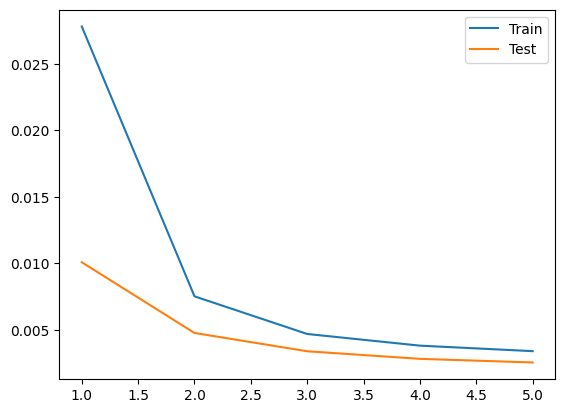

In [ ]:
plot_learning_curves(train_losses, test_losses)

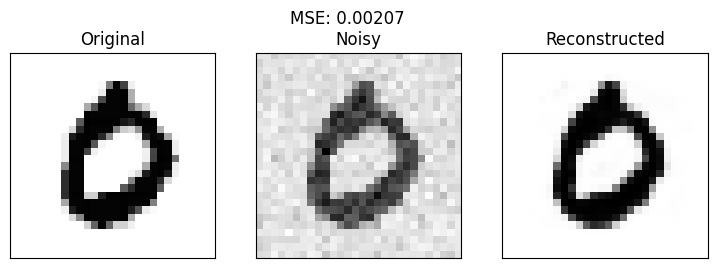

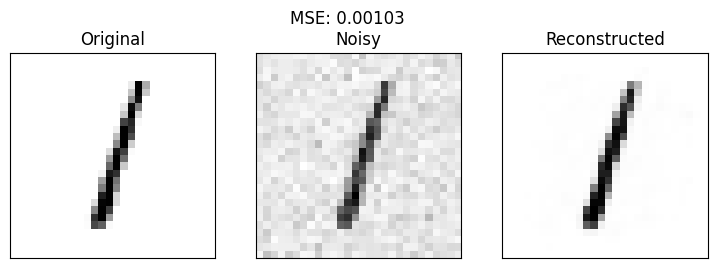

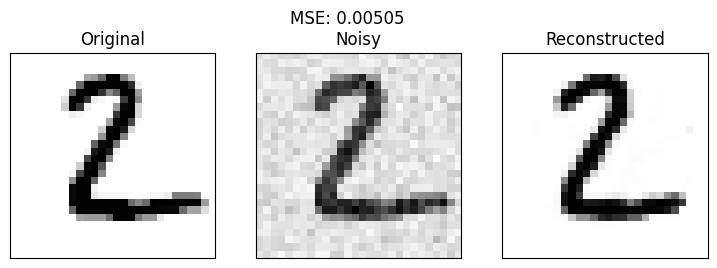

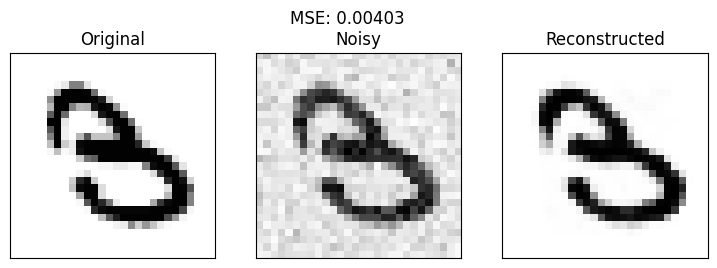

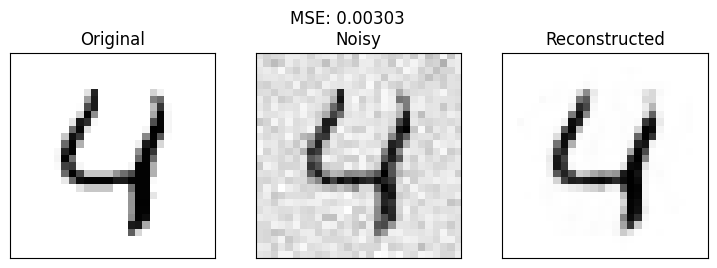

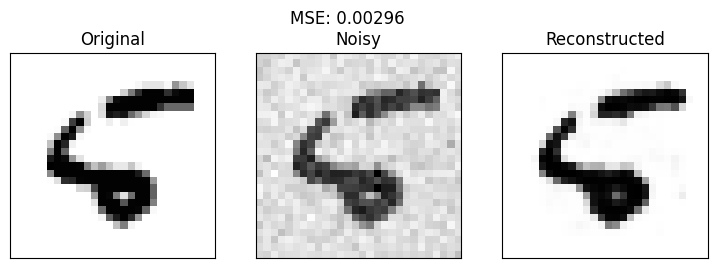

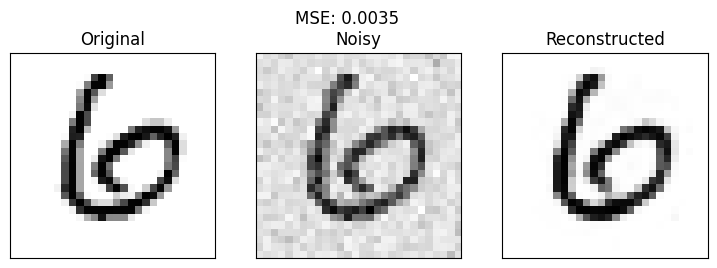

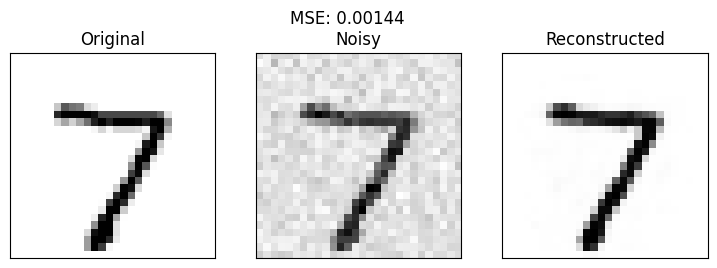

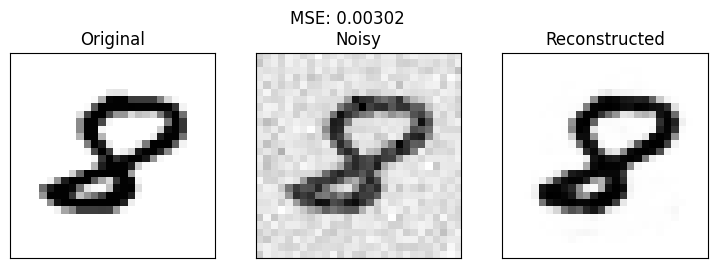

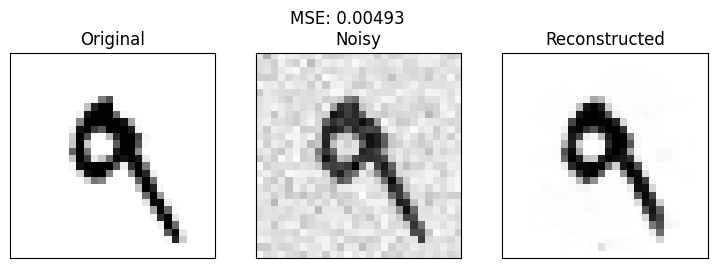

In [ ]:
visualize_reconstruction(dae, test_data, test_label, eps=0.1)

# Layer-wise pretraining

In [ ]:
layers = [784, 512, 256, 128]

deep_dae = None

for layer in layers[1:]:

  if deep_dae is None:
    deep_dae = DenoisingAutoEncoder([layers[0], layer])
  else:
    deep_dae.add_layer(layer)

  print(deep_dae)

  train(deep_dae, 3, True)

deep_dae.update_decoder()
deep_dae.switch_decoder()
deep_dae

DenoisingAutoEncoder(
  (encoder): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (decoder): ModuleList(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Sigmoid()
  )
  (backup_decoder): ModuleList()
)


Loss: 0.004683848470449448: 100%|██████████| 938/938 [00:21<00:00, 44.59it/s]


Epoch 1 loss: 0.017226013323184904



Loss: 0.0031872051768004894: 100%|██████████| 938/938 [00:22<00:00, 42.03it/s]


Epoch 2 loss: 0.003914455917707559



Loss: 0.0021855083759874105: 100%|██████████| 938/938 [00:24<00:00, 38.49it/s]


Epoch 3 loss: 0.00284709000060442



Loss: 0.002018869388848543: 100%|██████████| 157/157 [00:03<00:00, 42.64it/s]



Test loss: 0.0019396996506709297

DenoisingAutoEncoder(
  (encoder): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (decoder): ModuleList(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
  )
  (backup_decoder): ModuleList(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


Loss: 7.050161366350949e-05: 100%|██████████| 938/938 [00:21<00:00, 43.51it/s]


Epoch 1 loss: 0.03188770916447127



Loss: 2.5876590370899066e-05: 100%|██████████| 938/938 [00:22<00:00, 42.29it/s]


Epoch 2 loss: 9.637309362731176e-05



Loss: 0.0001110744196921587: 100%|██████████| 938/938 [00:21<00:00, 42.88it/s]


Epoch 3 loss: 2.9375444598356756e-05



Loss: 1.4473895134869963e-05: 100%|██████████| 157/157 [00:02<00:00, 62.83it/s]



Test loss: 1.5221599265847996e-05

DenoisingAutoEncoder(
  (encoder): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
  )
  (backup_decoder): ModuleList(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


Loss: 8.673056051122785e-09: 100%|██████████| 938/938 [00:22<00:00, 41.70it/s]


Epoch 1 loss: 5.8305853155085815e-05



Loss: 1.2211830835440196e-07: 100%|██████████| 938/938 [00:28<00:00, 32.90it/s]


Epoch 2 loss: 4.0458349298472665e-08



Loss: 2.5041288154170616e-08: 100%|██████████| 938/938 [00:28<00:00, 32.64it/s]


Epoch 3 loss: 3.934587864242514e-08



Loss: 6.847678690746761e-08: 100%|██████████| 157/157 [00:02<00:00, 75.34it/s]


Test loss: 1.3506080083907304e-07



DenoisingAutoEncoder(
  (encoder): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
# deep_dae = DenoisingAutoEncoder([784, 512, 256, 128])
deep_dae.unfreeze_parameters()
train_losses, test_losses = train(deep_dae, 5)

Loss: 0.021261150017380714: 100%|██████████| 938/938 [00:36<00:00, 25.74it/s]


Epoch 1 loss: 0.0426898159757892



Loss: 0.014609824866056442: 100%|██████████| 938/938 [00:41<00:00, 22.85it/s]


Epoch 2 loss: 0.018337202505635492



Loss: 0.013243123888969421: 100%|██████████| 938/938 [00:40<00:00, 22.93it/s]


Epoch 3 loss: 0.013601145916568762



Loss: 0.011088126339018345: 100%|██████████| 938/938 [00:41<00:00, 22.41it/s]


Epoch 4 loss: 0.011369546562600048



Loss: 0.011049110442399979: 100%|██████████| 938/938 [00:41<00:00, 22.34it/s]


Epoch 5 loss: 0.010127572611824218



Loss: 0.007681760936975479: 100%|██████████| 157/157 [00:01<00:00, 79.32it/s]


Test loss: 0.008996450496469714



In [ ]:
plot_learning_curves(train_losses, test_losses)

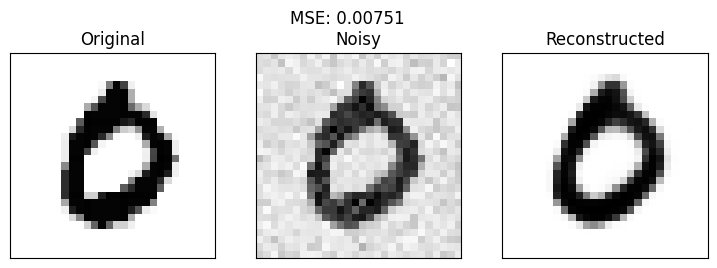

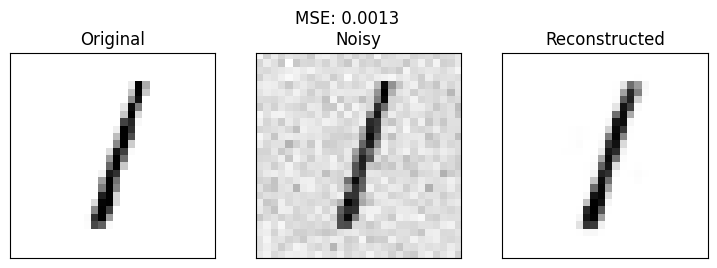

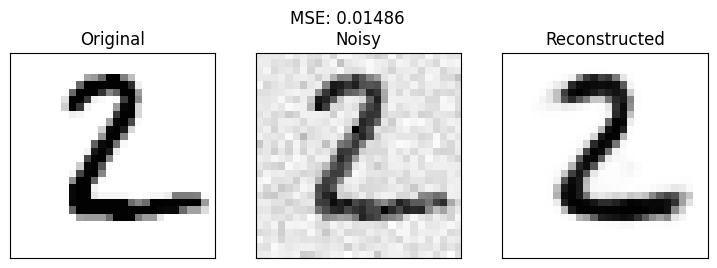

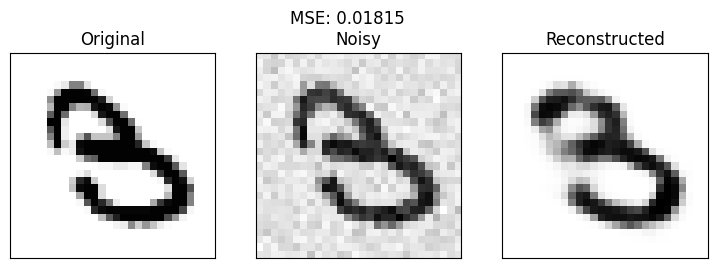

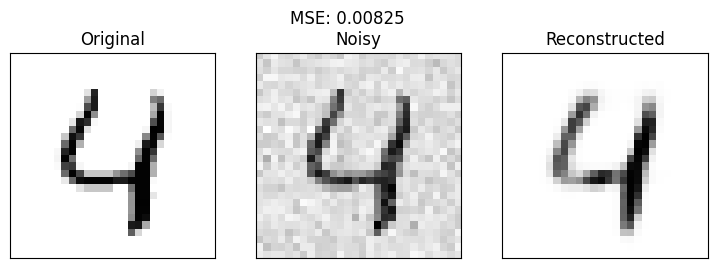

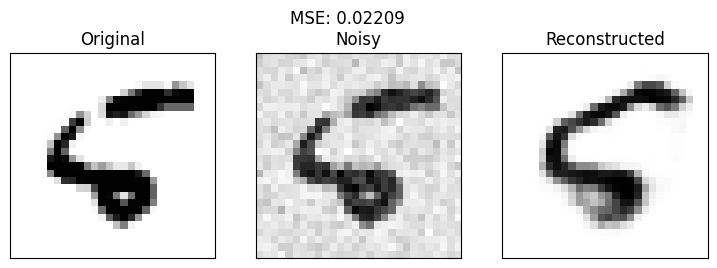

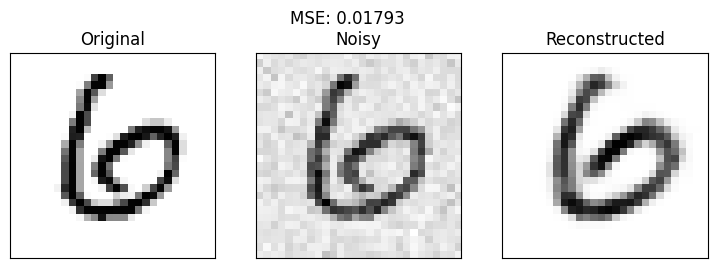

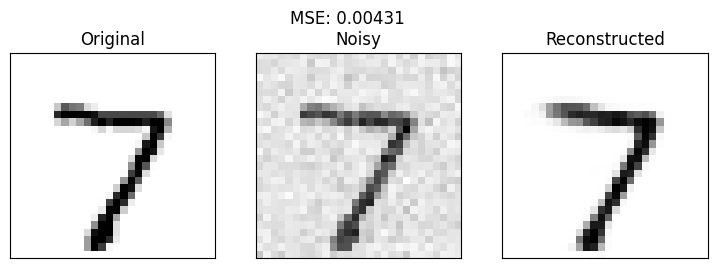

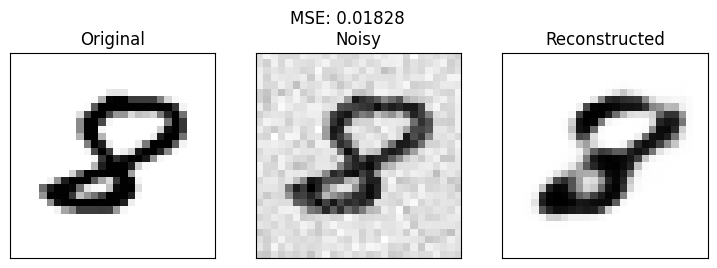

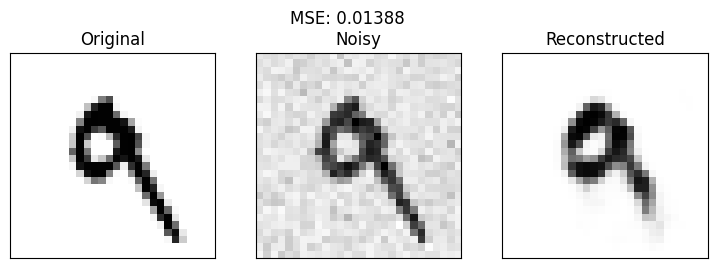

In [ ]:
visualize_reconstruction(deep_dae, test_data, test_label, eps=0.1)

## Direct training with no pre-training

In [ ]:
deep_dae_2 = DenoisingAutoEncoder([784, 512, 256, 128])
train_losses, test_losses = train(deep_dae_2, 5)

Loss: 0.02039797604084015: 100%|██████████| 938/938 [00:30<00:00, 31.11it/s]


Epoch 1 loss: 0.03605649594876812



Loss: 0.012840180657804012: 100%|██████████| 938/938 [00:35<00:00, 26.26it/s]


Epoch 2 loss: 0.016836609362737773



Loss: 0.013409005478024483: 100%|██████████| 938/938 [00:36<00:00, 25.82it/s]


Epoch 3 loss: 0.012690230560645874



Loss: 0.01141150388866663: 100%|██████████| 938/938 [00:36<00:00, 25.40it/s]


Epoch 4 loss: 0.010500322565682597



Loss: 0.008400142192840576: 100%|██████████| 938/938 [00:36<00:00, 25.47it/s]


Epoch 5 loss: 0.009318099184426417



Loss: 0.008307602256536484: 100%|██████████| 157/157 [00:01<00:00, 87.73it/s]


Test loss: 0.008552558984085443



In [ ]:
plot_learning_curves(train_losses, test_losses)

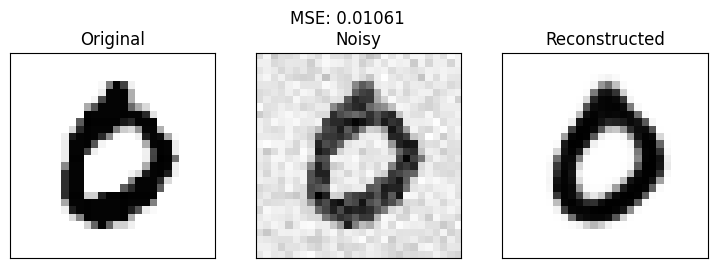

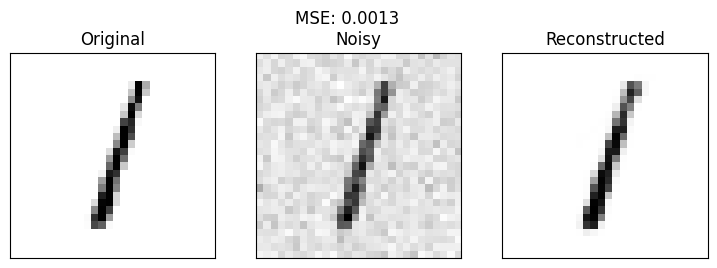

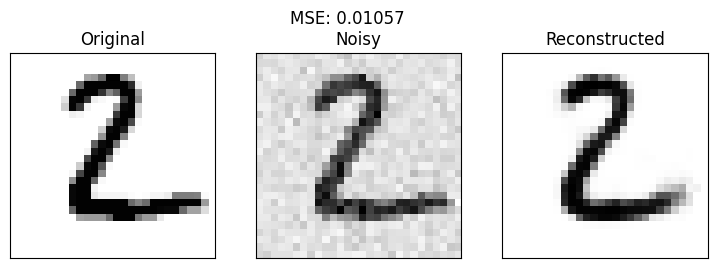

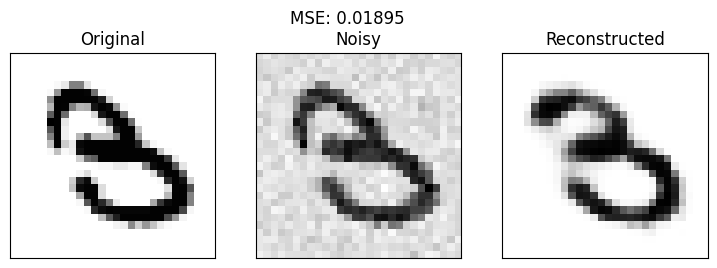

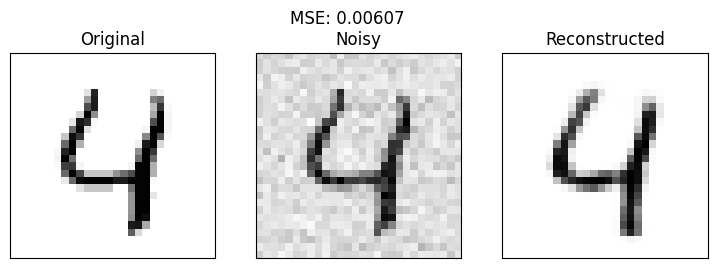

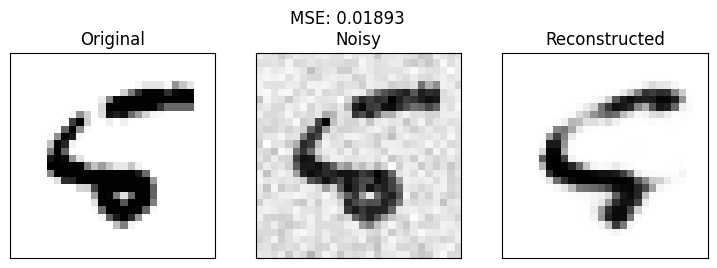

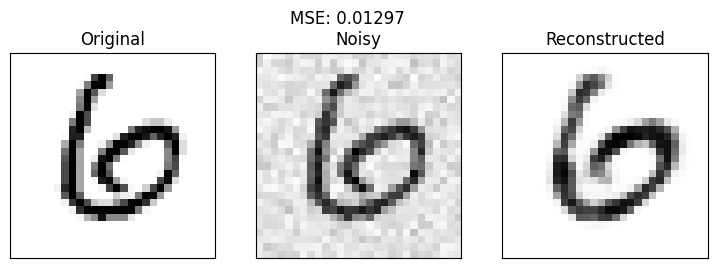

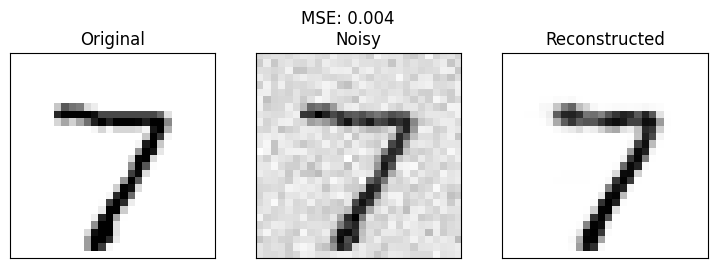

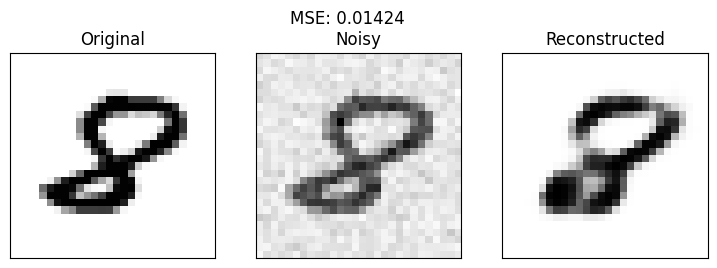

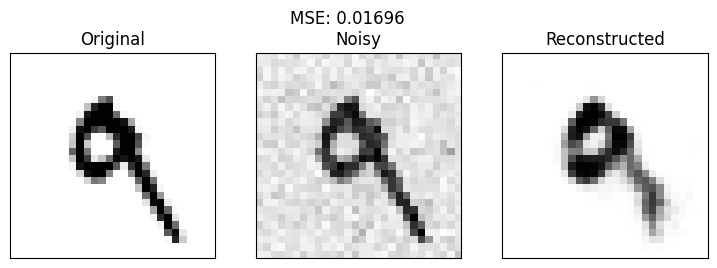

In [ ]:
visualize_reconstruction(deep_dae_2, test_data, test_label, eps=0.1)

## Interpolation

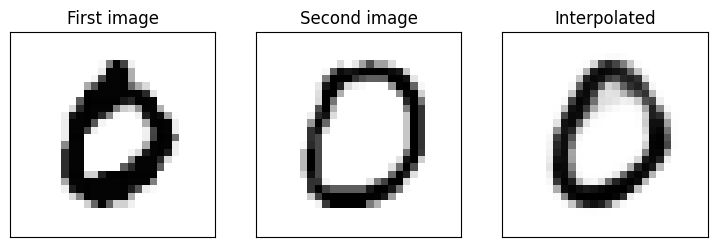

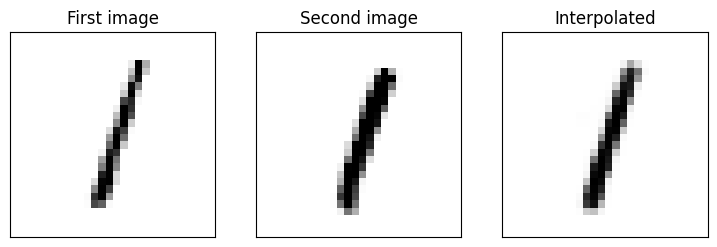

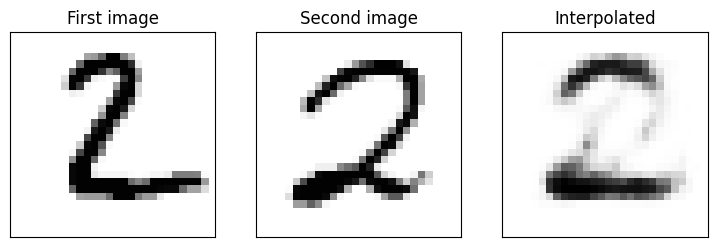

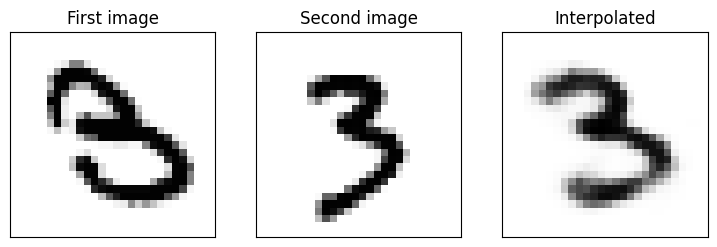

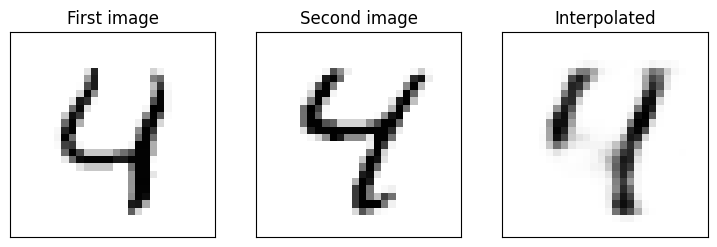

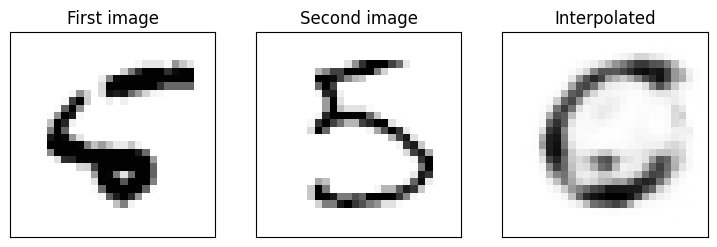

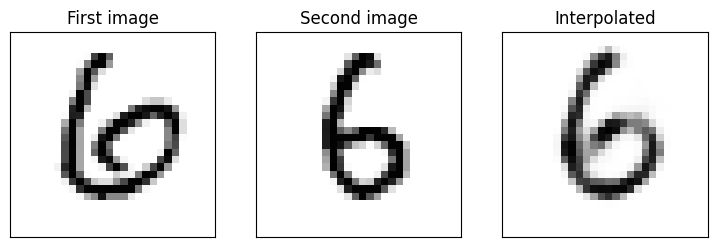

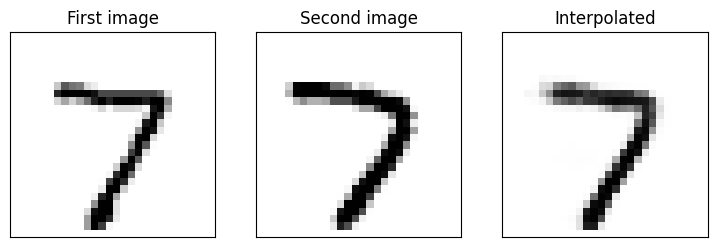

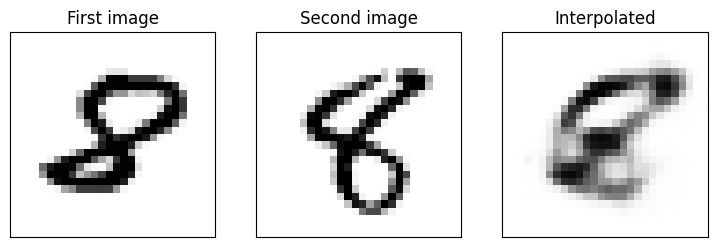

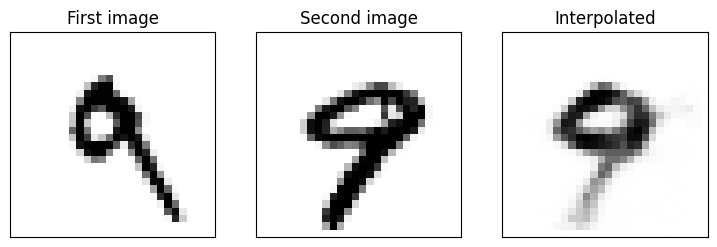

In [ ]:
test_interpolation_same_class(deep_dae_2, test_data, test_label, alpha=0.5)

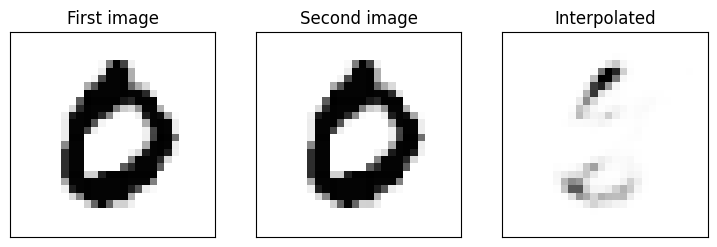

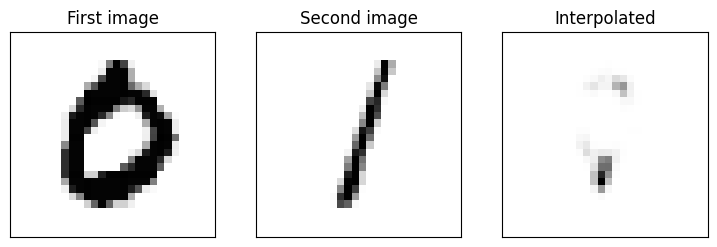

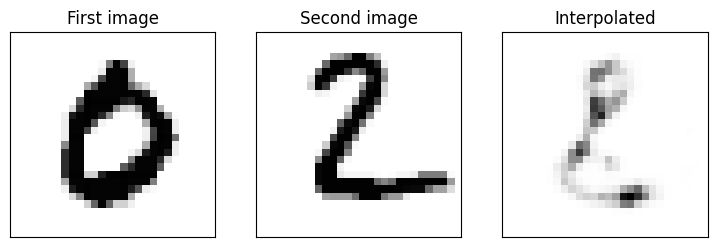

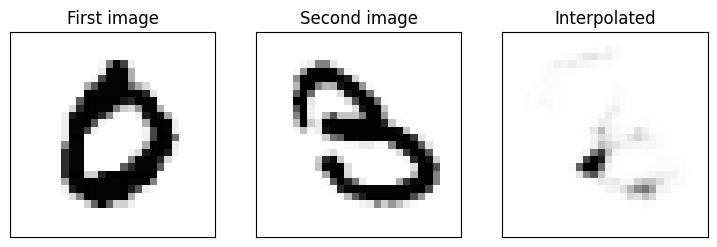

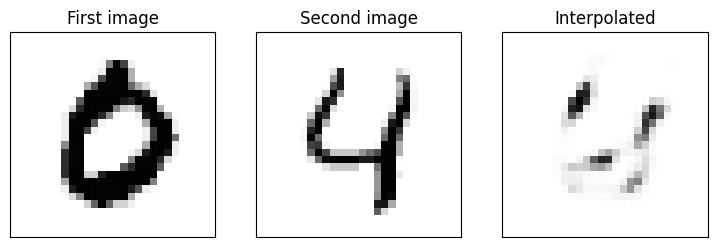

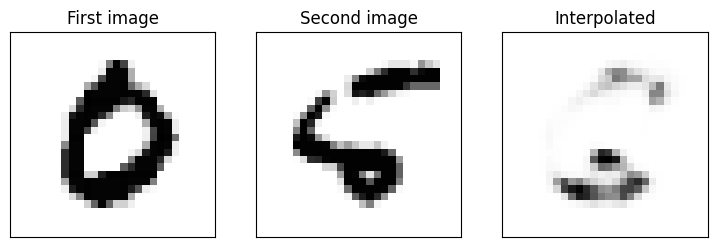

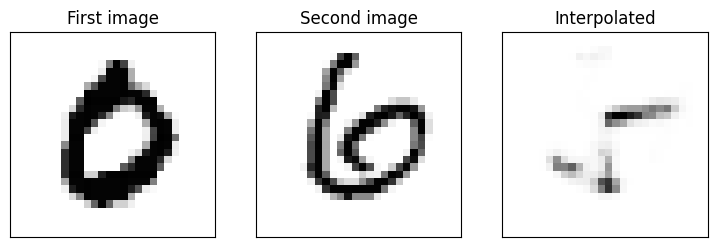

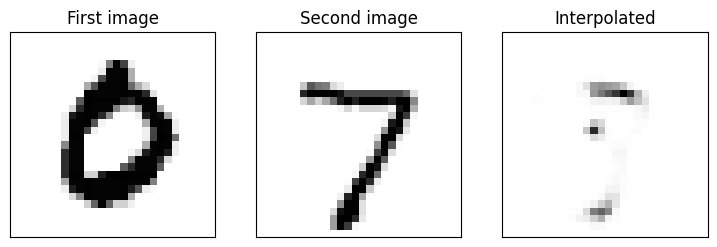

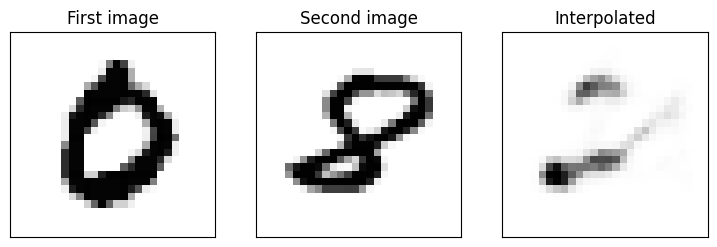

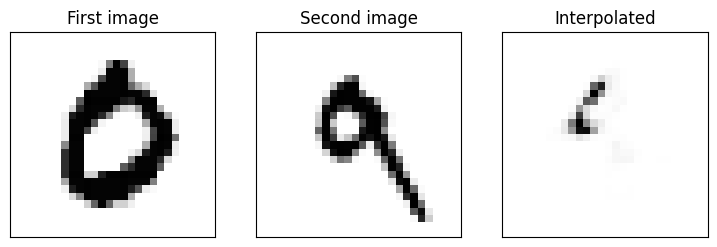

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 0, alpha=0.5)

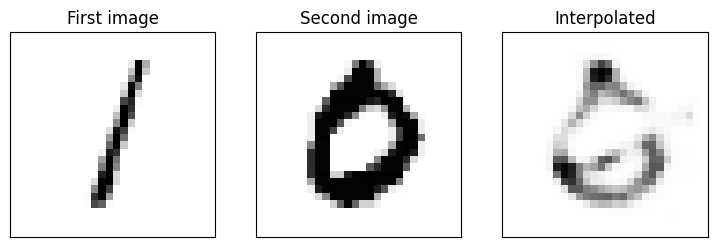

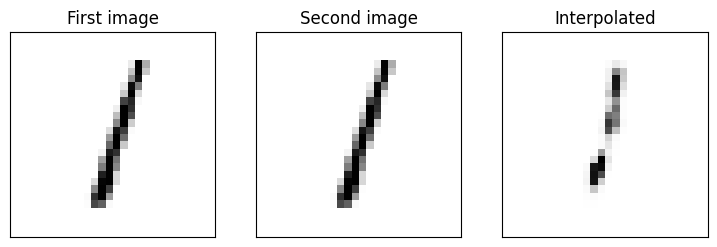

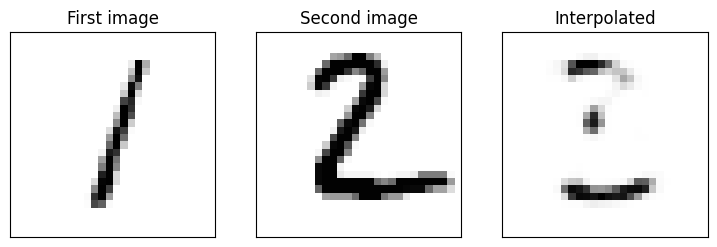

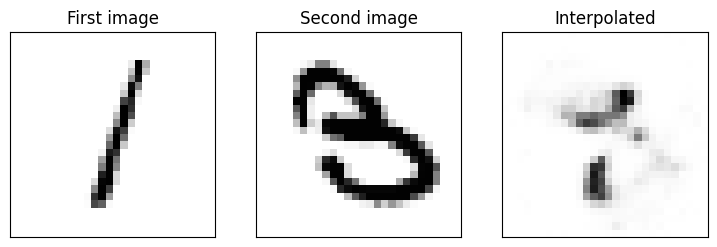

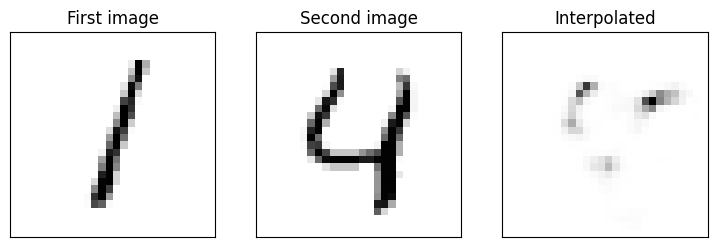

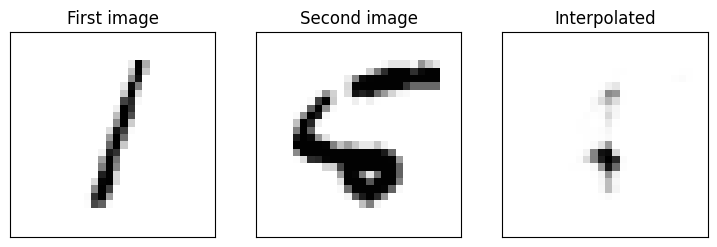

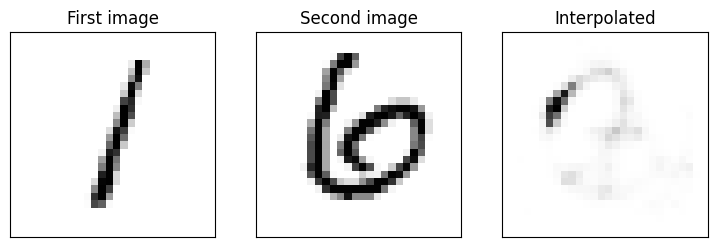

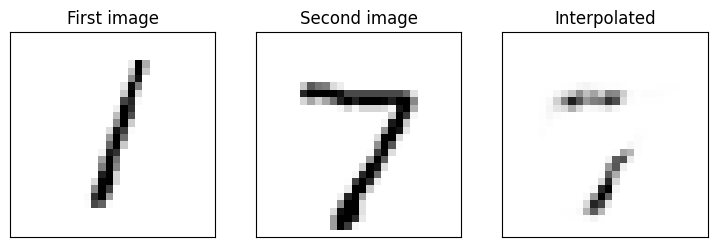

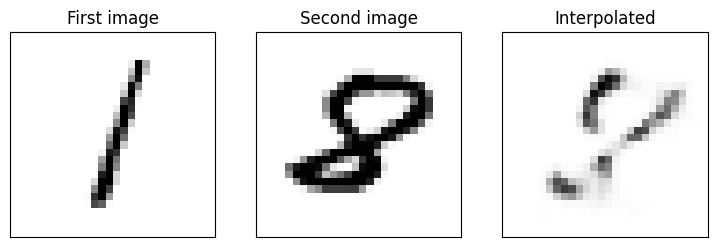

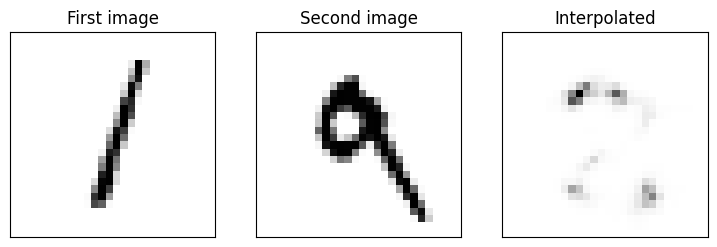

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 1, alpha=0.5)

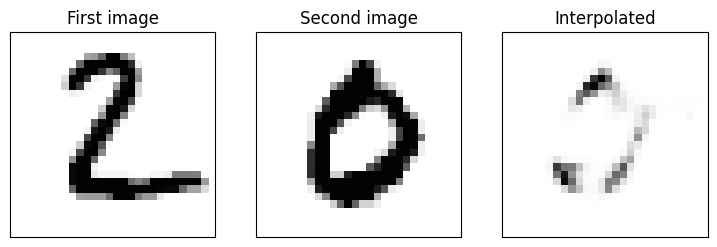

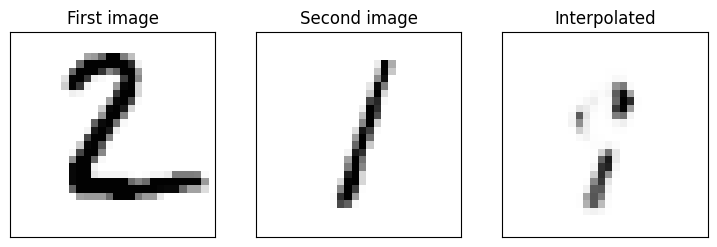

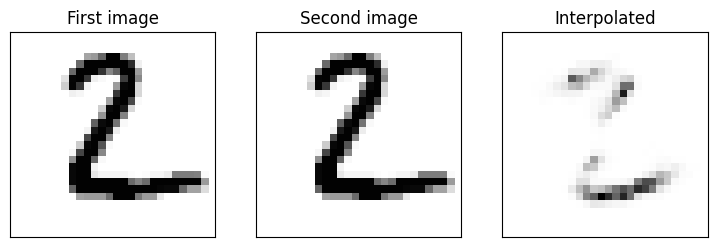

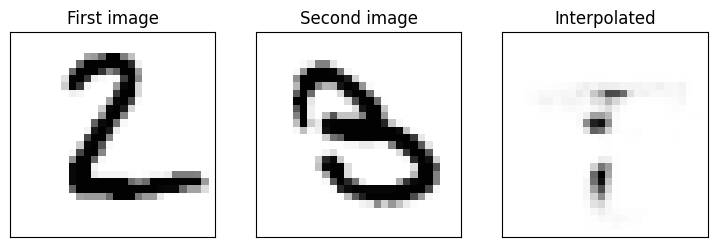

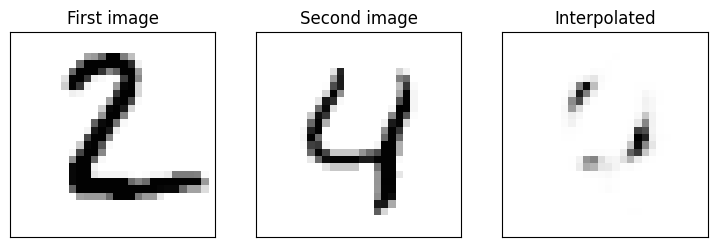

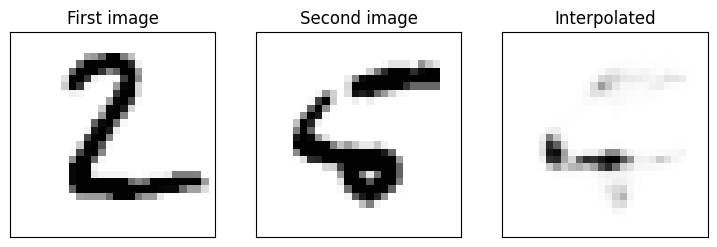

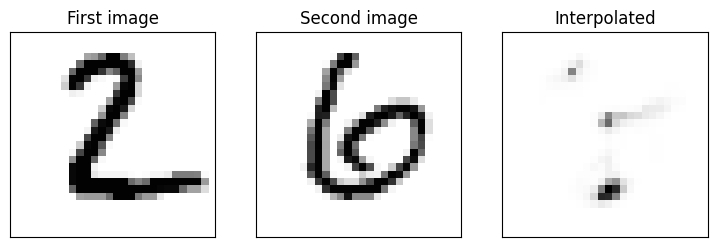

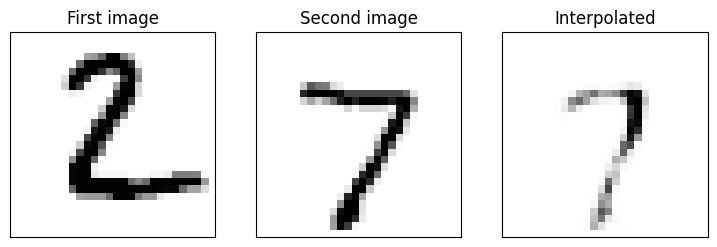

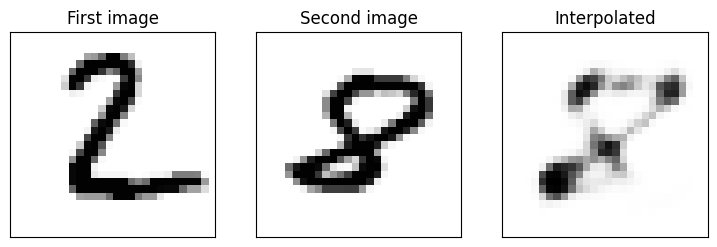

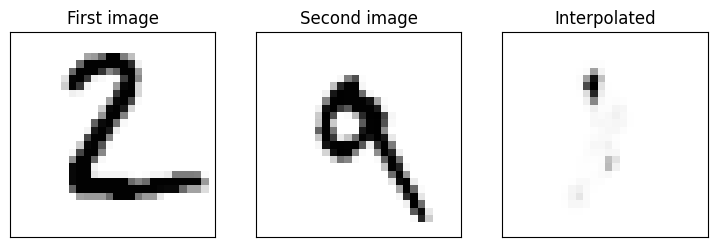

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 2, alpha=0.5)

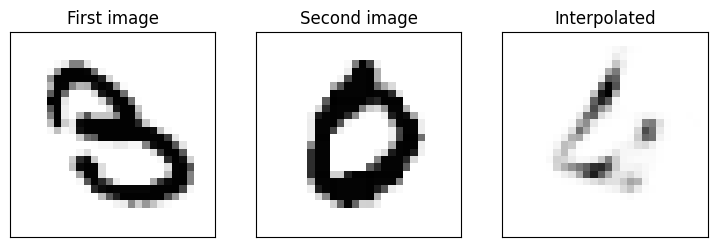

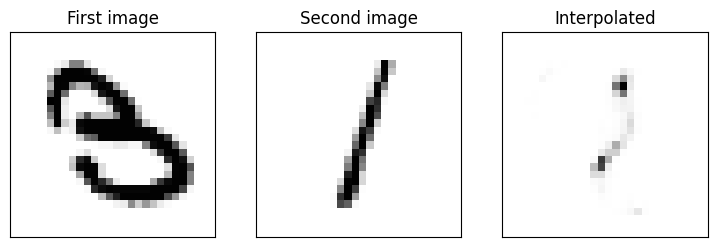

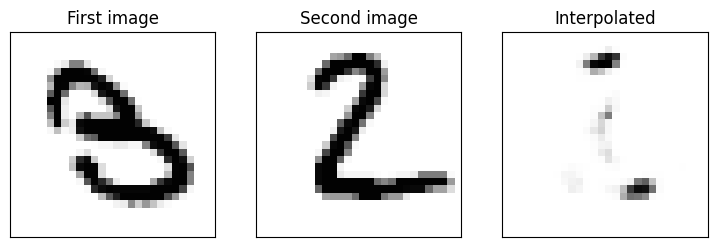

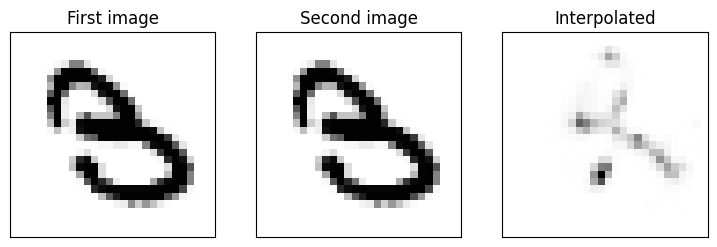

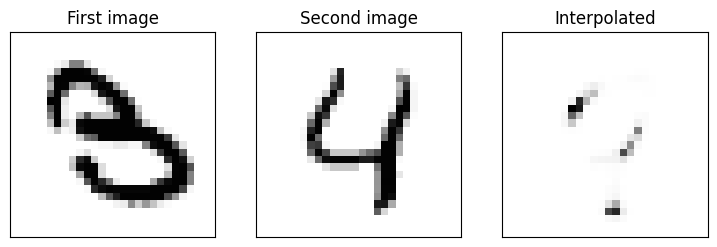

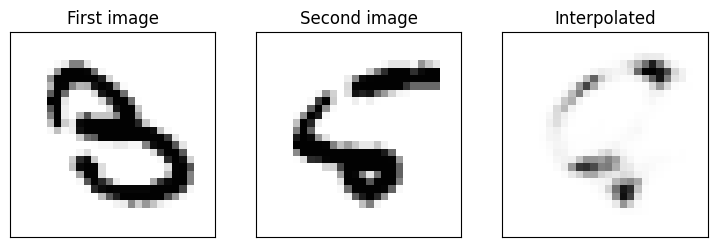

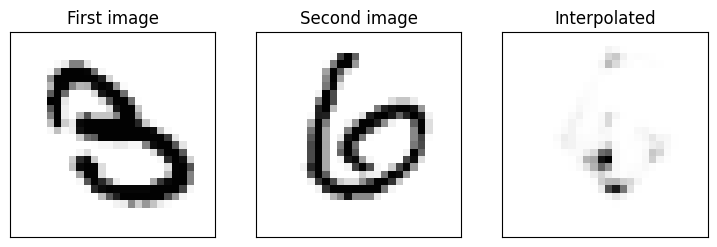

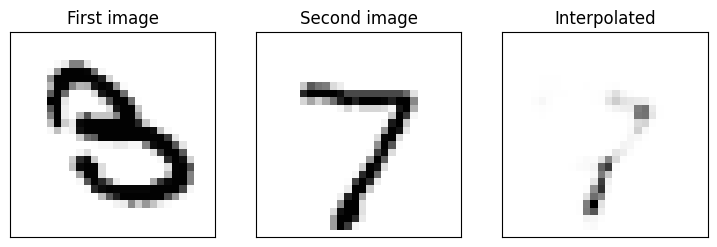

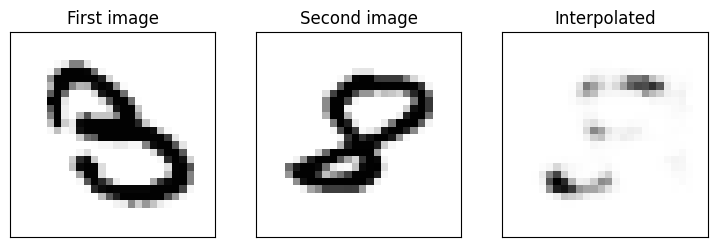

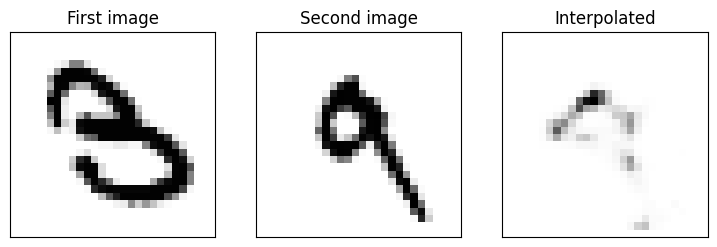

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 3, alpha=0.5)

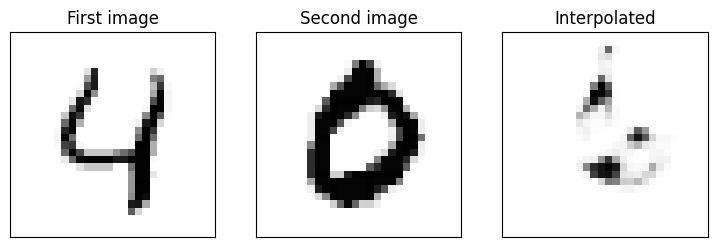

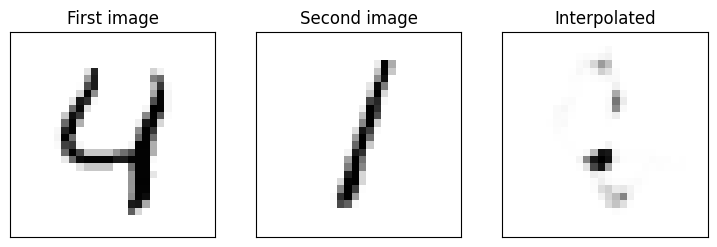

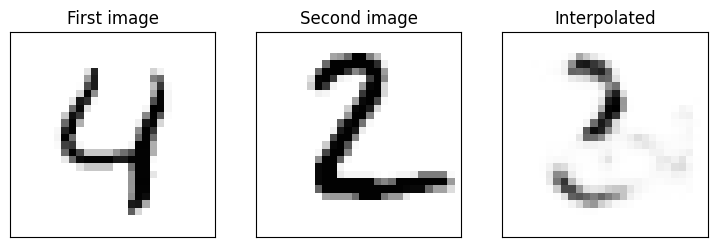

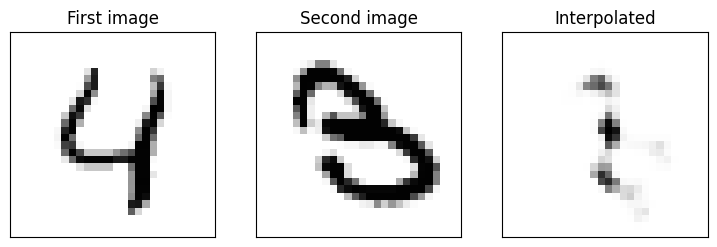

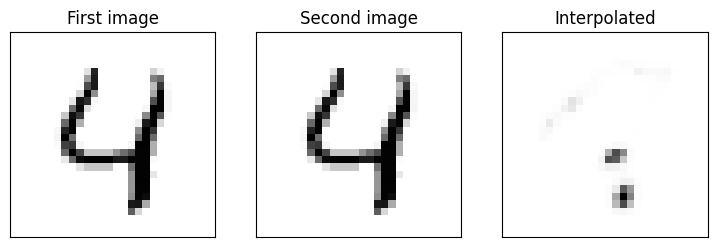

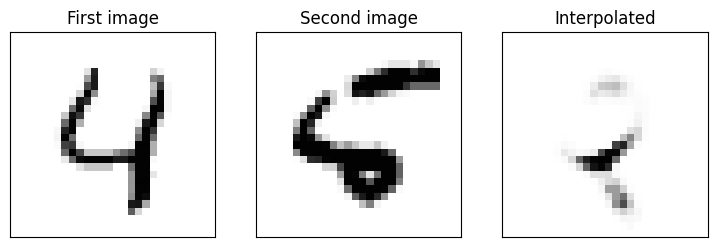

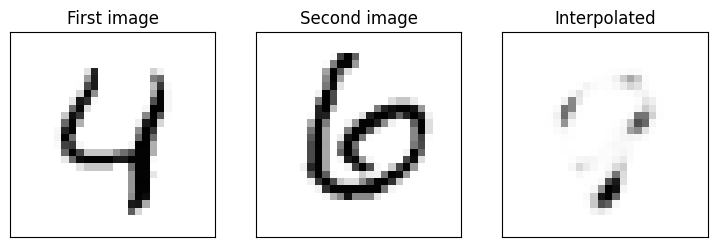

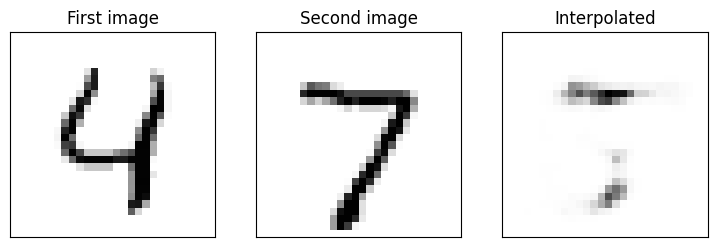

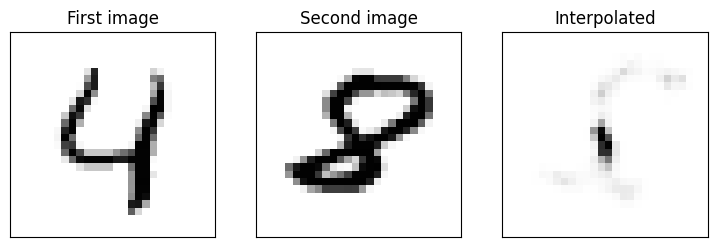

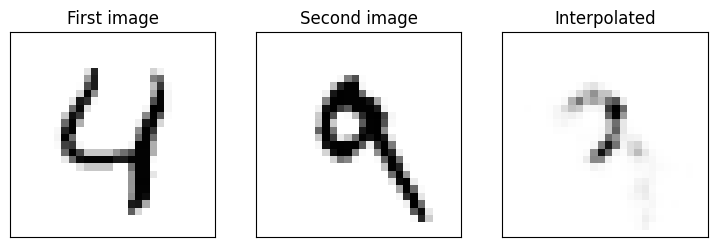

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 4, alpha=0.5)

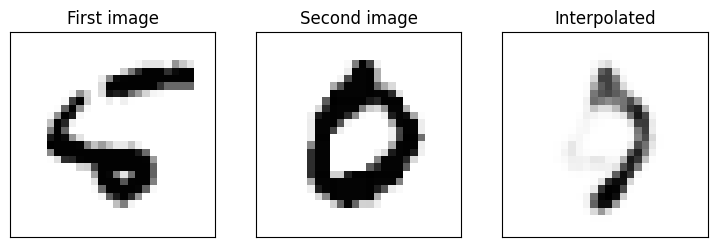

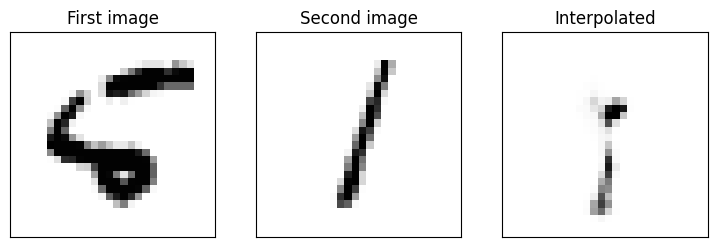

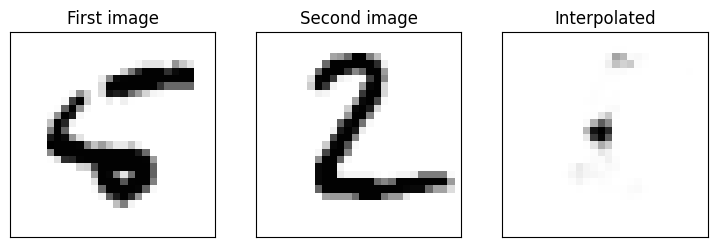

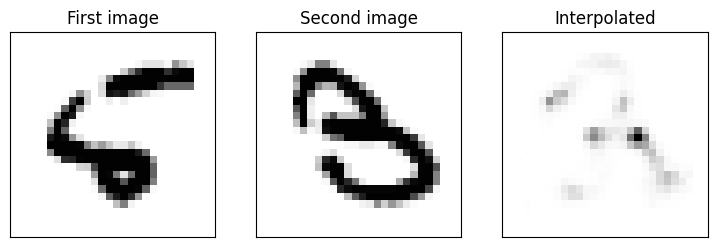

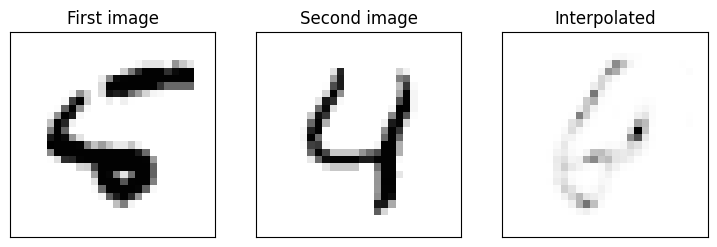

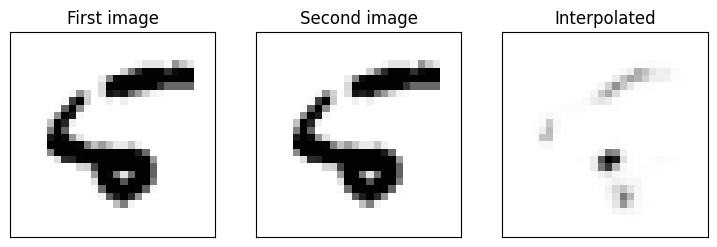

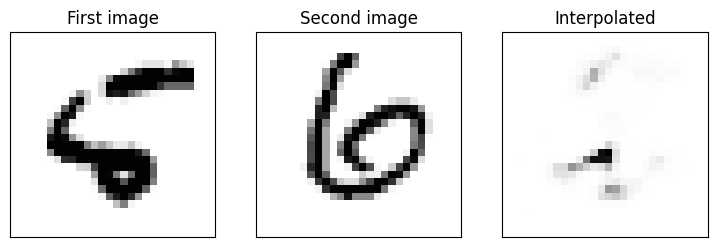

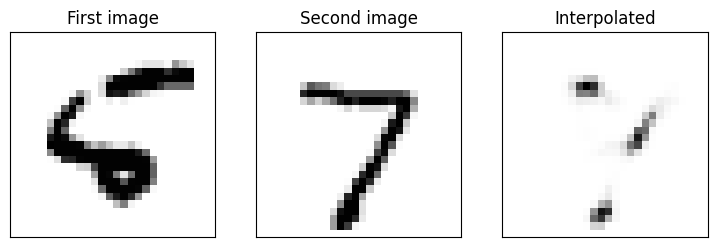

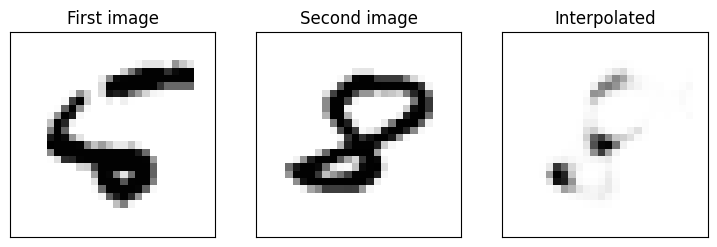

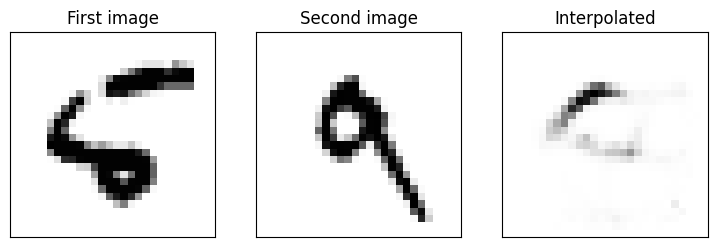

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 5, alpha=0.5)

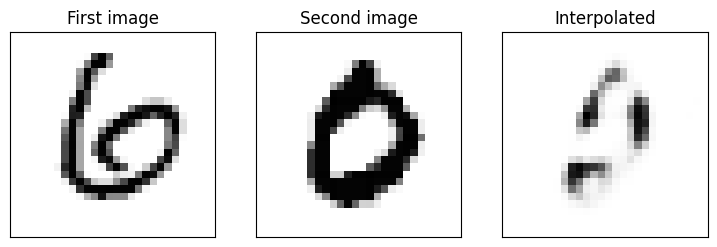

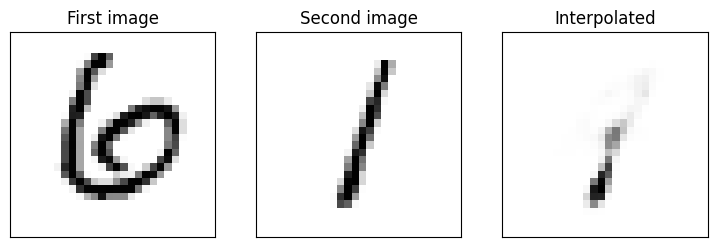

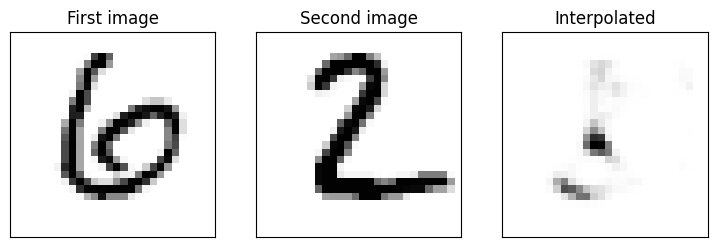

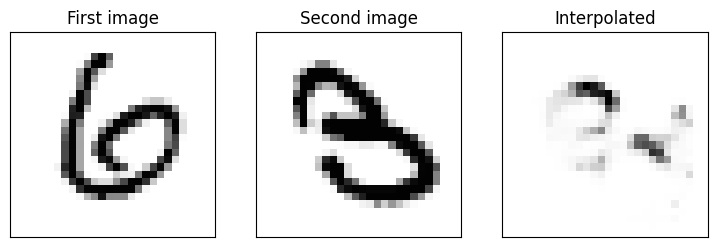

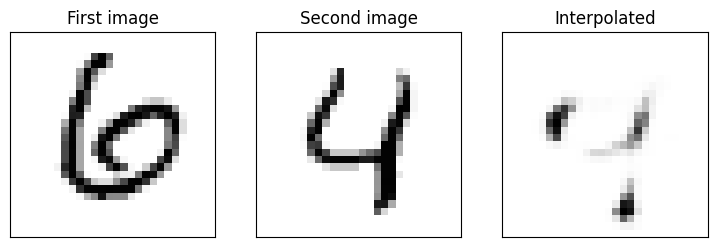

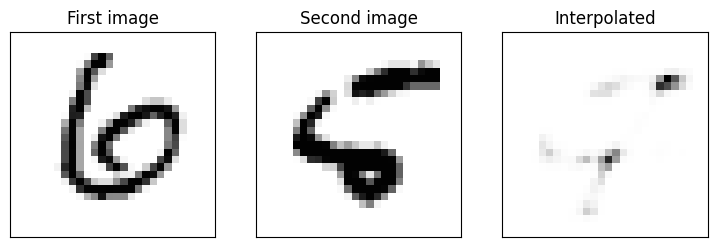

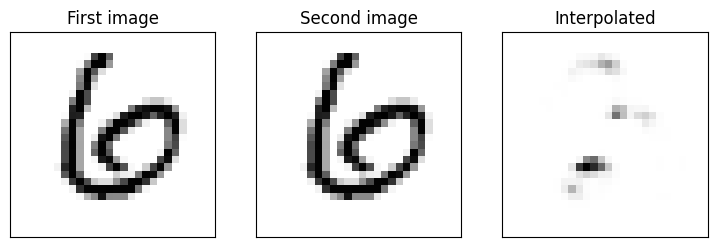

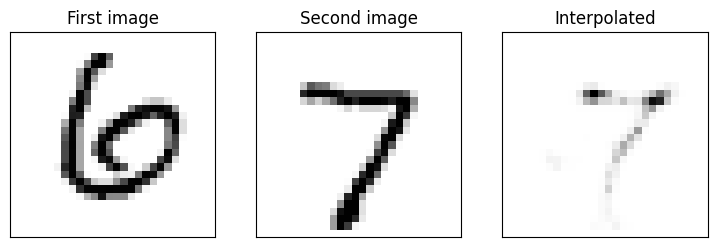

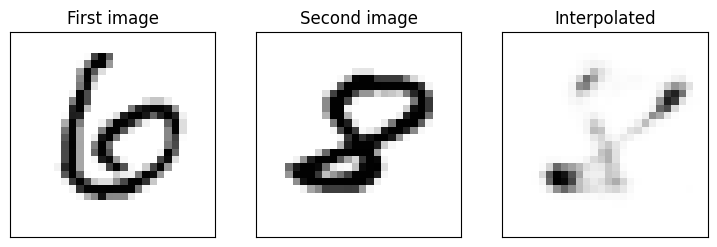

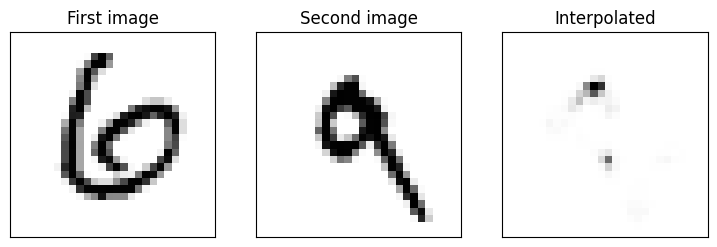

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 6, alpha=0.5)

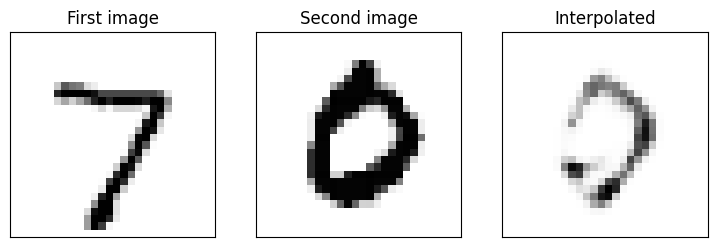

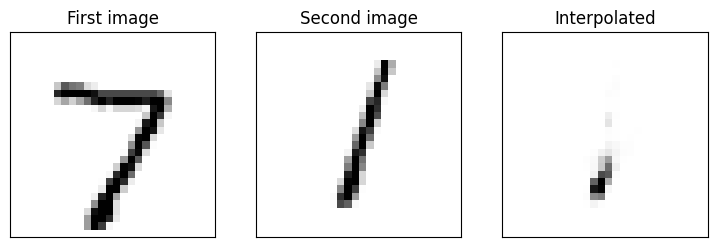

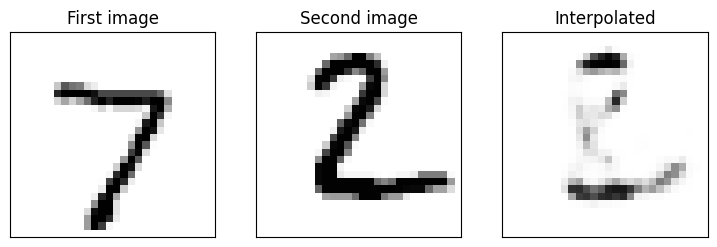

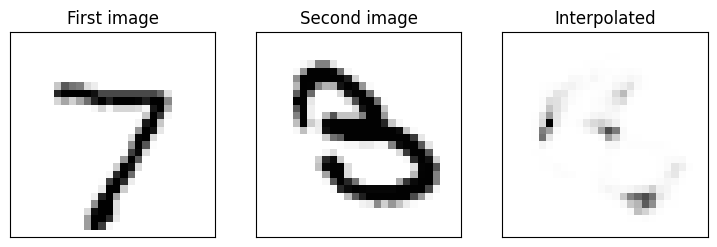

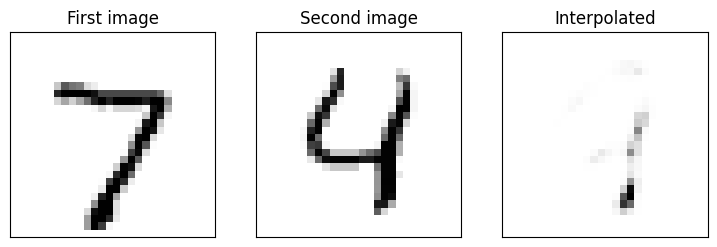

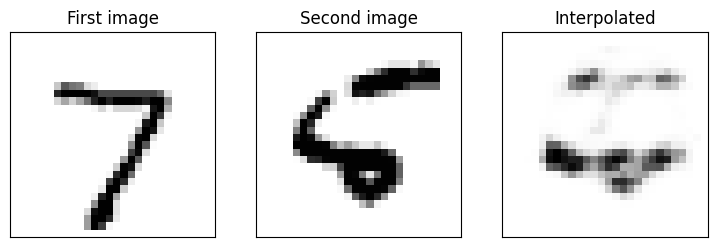

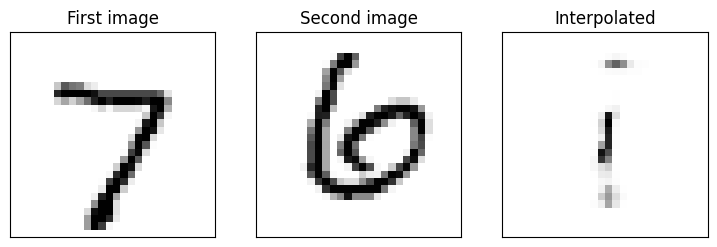

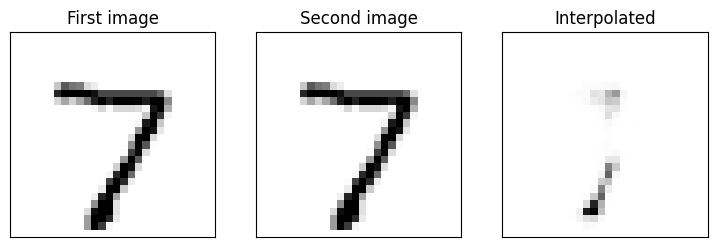

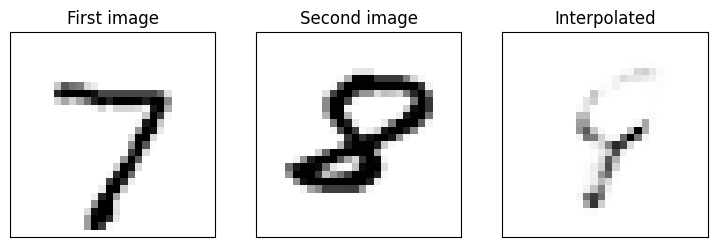

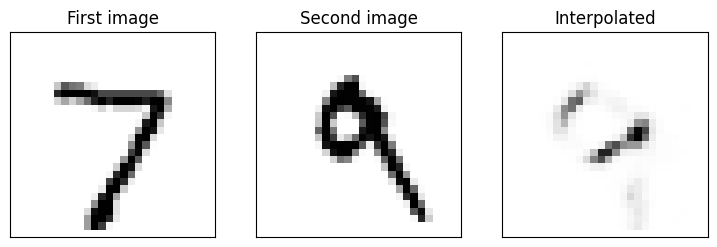

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 7, alpha=0.5)

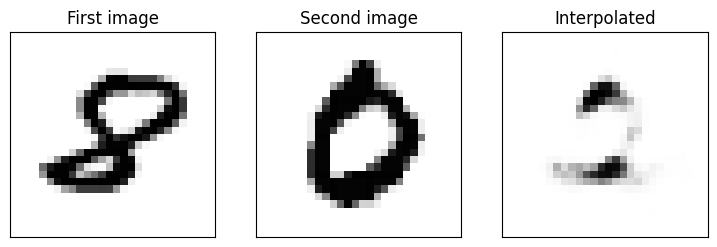

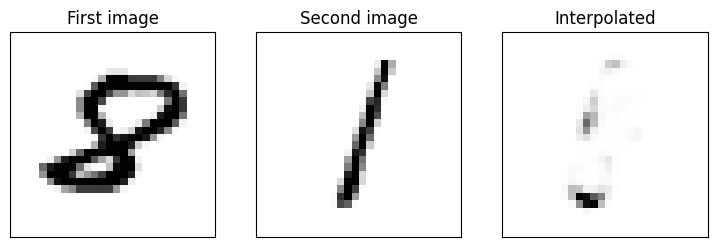

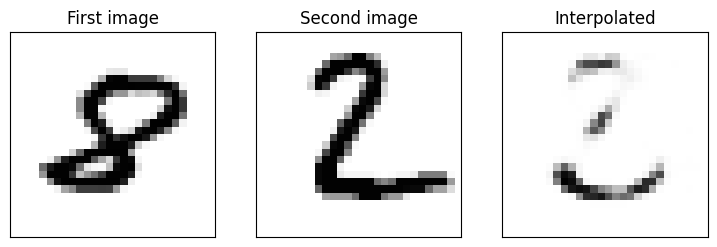

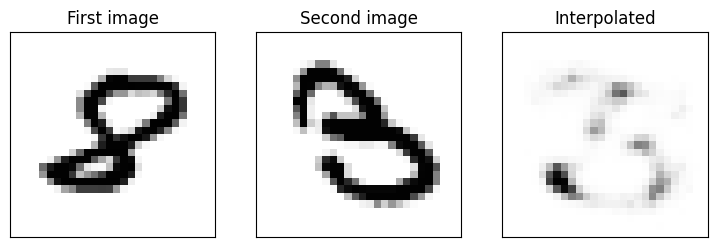

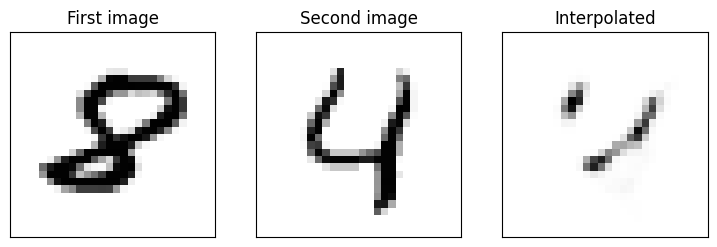

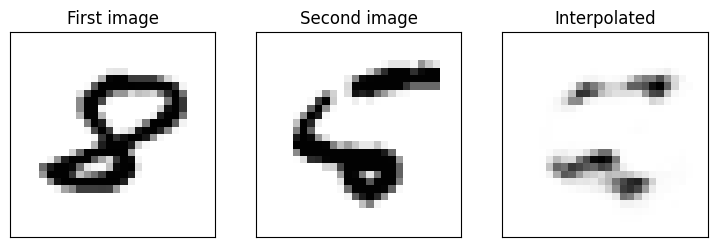

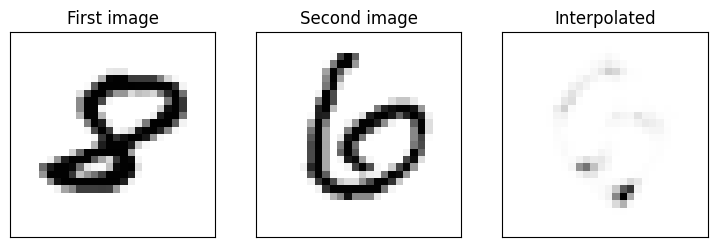

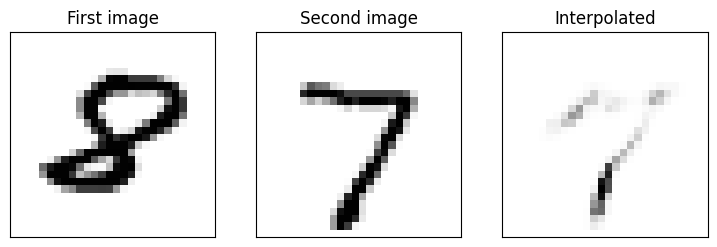

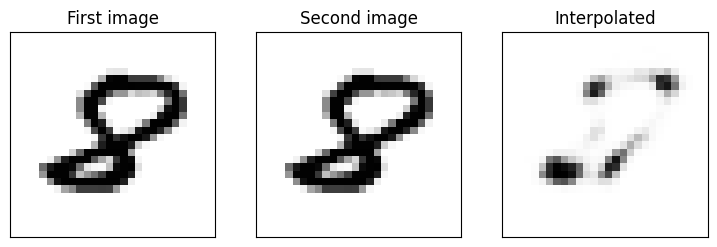

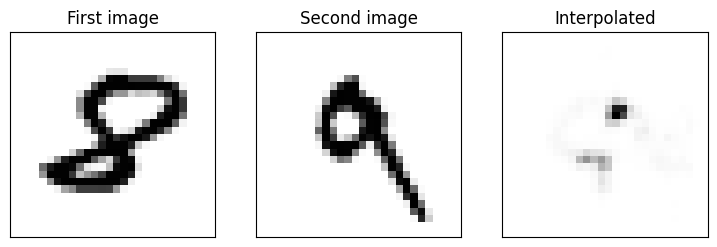

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 8, alpha=0.5)

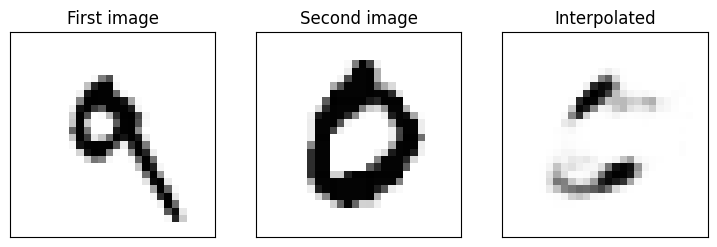

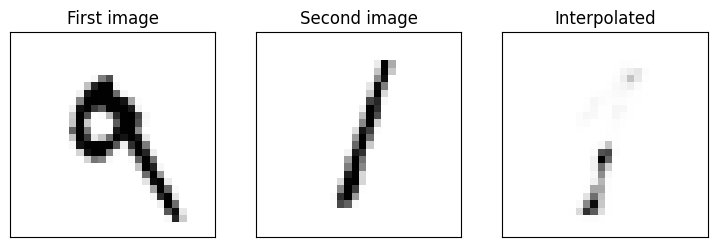

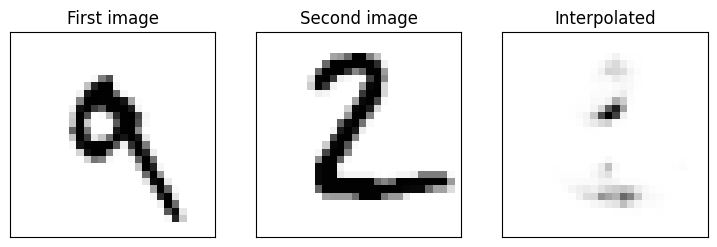

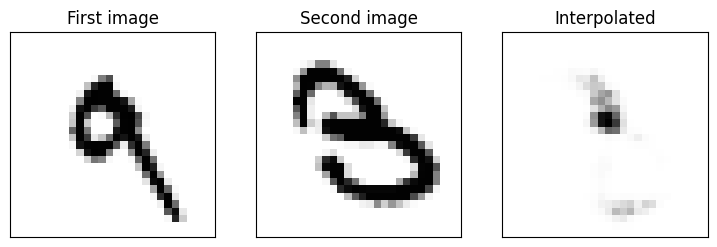

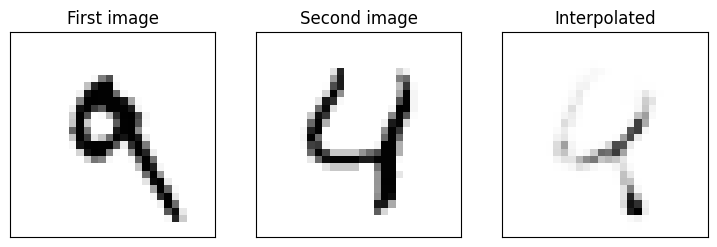

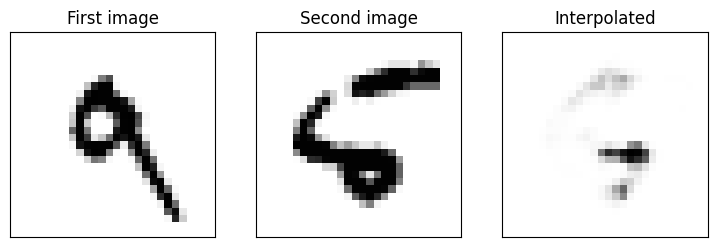

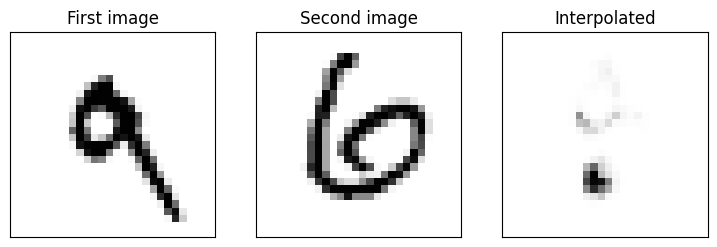

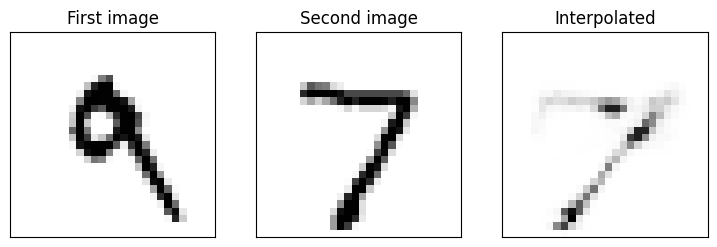

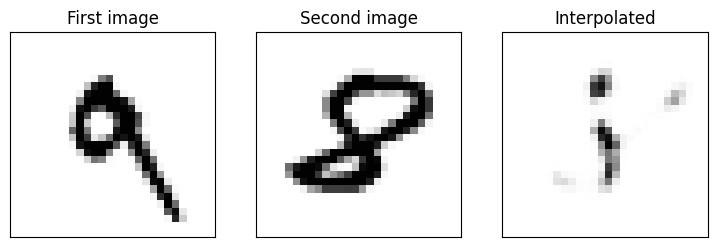

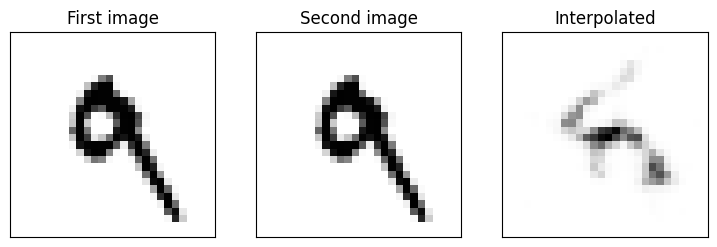

In [ ]:
test_interpolation(deep_dae_2, test_data, test_label, 9, alpha=0.5)